In [179]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline
import sys
import numpy as np
from scipy import signal, optimize
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
from neurodsp import sim, spectral
from seaborn import despine
import brian2 as b2

sys.path.append('../')
import echo_utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)

fig_path = '../figures/sim/%s.pdf'
save_plot=True



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
fs = 2000.
# t_sim = 2.
# t_ker = np.arange(0,t_sim,1/fs)
# t_r = 0
t_ds = np.arange(0.005,0.08,0.01)
f_to_plot=200
# kernels = []

# simulate noise
T = 180
noise, ac = [], []
for t_d in t_ds:
    noise.append(sim.sim_synaptic_current(T, fs, tau_d = t_d))
    ac.append(signal.correlate(noise[-1], noise[-1])[int(T*fs)-1:])

noise = np.vstack(noise)
ac = np.vstack(ac).T

f_axis, PSD = spectral.compute_spectrum(noise,fs)

# FOOOF PSDs without knee
fg = FOOOFGroup(aperiodic_mode='knee', max_n_peaks=0)
fg.fit(freqs=f_axis, power_spectra=PSD, freq_range=(2,200))
fit_knee = fg.get_params('aperiodic_params', 'knee')
fit_exp = fg.get_params('aperiodic_params', 'exponent')
knee_freq, taus = echo_utils.convert_knee_val(fit_knee, fit_exp)
P_knee = [PSD[i,np.argmin(np.abs((f_axis[:f_to_plot]-(knee_freq[i]))))] for i in range(len(t_ds))]

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



# Autocorrelation of Additive Independent Noise

In [93]:
add_noise = noise[0]+noise[-1]
ac_combined = signal.correlate(add_noise, add_noise)[int(T*fs)-1:]
f_axis, PSD_combined = spectral.compute_spectrum(add_noise,fs)

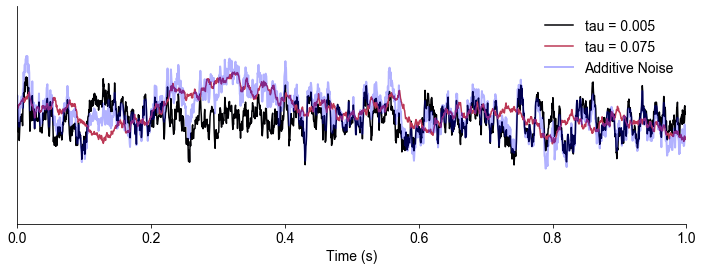

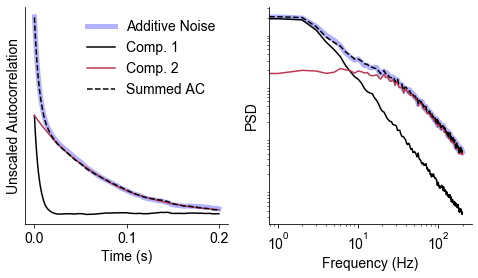

In [119]:
color = plt.cm.inferno(np.linspace(0,1,3))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

t = np.arange(0,T,1/fs)
plt.figure(figsize=(12,4))
plt.plot(t, noise[0], label='tau = %.3f'%t_ds[0])
plt.plot(t, noise[-1], label='tau = %.3f'%t_ds[-1])
plt.plot(t, add_noise, 'b', lw=2, alpha=0.3, label='Additive Noise')
plt.legend(frameon=False, loc='upper right')
plt.xlabel('Time (s)'); plt.yticks([]); plt.xlim([0, 1]); despine()

t_plot = 400
t_ac = np.arange(0,t_plot)/fs
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(t_ac, ac_combined[:t_plot], 'b', lw=5, alpha=0.3, label='Additive Noise')
plt.plot(t_ac,ac[:t_plot, 0], label='Comp. 1')
plt.plot(t_ac,ac[:t_plot, -1], label='Comp. 2')
plt.plot(t_ac,ac[:t_plot, -1]+ac[:t_plot, 0], 'k--', label='Summed AC')
plt.xlabel('Time (s)'); plt.ylabel('Unscaled Autocorrelation'); plt.yticks([]); plt.legend(frameon=False)
despine()

plt.subplot(1,2,2)
plt.loglog(f_axis[:f_to_plot], PSD_combined[:f_to_plot], 'b', lw=5, alpha=0.3)
plt.loglog(f_axis[:f_to_plot], PSD[-1][:f_to_plot])
plt.loglog(f_axis[:f_to_plot], PSD[0][:f_to_plot])
plt.plot(f_axis[:f_to_plot], PSD[0][:f_to_plot]+PSD[-1][:f_to_plot], 'k--')
plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD'); plt.yticks([])
despine()

### Autocorrelation of Sum of Uncorrelated Noise is Additive
Probably could've Googled this but here it is. The challenge will probably be fitting the model well.

In [141]:
def exp2_func(t, tau1, tau2, k1, k2):
    return k1*np.exp(-t/tau1) + k2*np.exp(-t/tau2)

def exp1_func(t, tau1, k1):
    return k1*np.exp(-t/tau1)

[0.05264955 0.67180775]
[0.00424615 0.06527963 0.47202453 0.54050833]


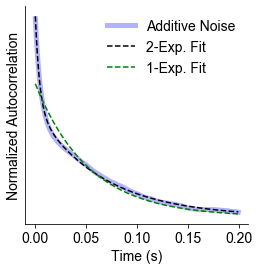

In [178]:
ac_norm = ac_combined[:t_plot]/ac_combined[0]
ac_ex = exp2_func(t_ac, p2e[0], p2e[1], p2e[2], p2e[3])

param_bounds1 =([0, 0], [10, np.inf])
param_bounds2 =([0, 0, 0, 0], [10, 10, np.inf, np.inf])

p1e = optimize.curve_fit(exp1_func, t_ac, ac_norm, bounds = param_bounds1)[0]
p2e = optimize.curve_fit(exp2_func, t_ac, ac_norm, bounds = param_bounds2)[0]

plt.figure(figsize=(4,4))
plt.plot(t_ac, ac_norm, 'b', lw=5, alpha=0.3, label='Additive Noise')
plt.plot(t_ac, exp2_func(t_ac, p2e[0], p2e[1], p2e[2], p2e[3]), '--', label='2-Exp. Fit')
plt.plot(t_ac, exp1_func(t_ac, p1e[0], p1e[1]), '--g', label='1-Exp. Fit')
plt.ylabel('Normalized Autocorrelation'); plt.yticks([]); plt.xlabel('Time (s)'); plt.legend(frameon=False)

print(p1e)
print(p2e)
despine()

---
# Simulating Timescale Separation of LFP and Spiking

In [180]:
b2.

<module 'brian2' from '/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/brian2/__init__.py'>